In [1]:
# uci_digits_auto_anomaly.py

# autoencoder reconstruction error anomaly detection
# uses an encoder-decoder architecture
# PyTorch 1.8.0-CPU Anaconda3-2020.02  Python 3.7.6
# Windows 10 

import numpy as np
import matplotlib.pyplot as plt
import torch as T

device = T.device("cpu") 

In [2]:
# -----------------------------------------------------------

class UCI_Digits_Dataset(T.utils.data.Dataset):
  # 8,12,0,16, . . 15,7
  # 64 pixel values [0-16], digit [0-9]

  def __init__(self, src_file, n_rows=None):
    all_xy = np.loadtxt(src_file, max_rows=n_rows,
      usecols=range(0,65), delimiter=",", comments="#",
      dtype=np.float32)
    self.xy_data = T.tensor(all_xy, dtype=T.float32).to(device) 
    self.xy_data[:, 0:64] /= 16.0   # normalize pixels
    self.xy_data[:, 64] /= 9.0      # normalize digit/label

  def __len__(self):
    return len(self.xy_data)

  def __getitem__(self, idx):
    xy = self.xy_data[idx]
    return xy

# -----------------------------------------------------------

In [3]:
# -----------------------------------------------------------

class Autoencoder(T.nn.Module):  # 65-32-8-32-65
  def __init__(self):
    super(Autoencoder, self).__init__()
    self.fc1 = T.nn.Linear(65, 32)
    self.fc2 = T.nn.Linear(32, 8)
    self.fc3 = T.nn.Linear(8, 32)
    self.fc4 = T.nn.Linear(32, 65)

  def encode(self, x):  # 65-32-8
    z = T.tanh(self.fc1(x))
    z = T.tanh(self.fc2(z))  # latent in [-1,+1]
    return z  

  def decode(self, x):  # 8-32-65
    z = T.tanh(self.fc3(x))
    z = T.sigmoid(self.fc4(z))  # [0.0, 1.0]
    return z
    
  def forward(self, x):
    z = self.encode(x) 
    z = self.decode(z) 
    return z  # in [0.0, 1.0]

# -----------------------------------------------------------


In [4]:
# -----------------------------------------------------------

def display_digit(ds, idx, save=False):
  # ds is a PyTorch Dataset
  line = ds[idx]  # tensor
  pixels = np.array(line[0:64])  # numpy row of pixels
  label = np.int(line[64] * 9.0)  # denormalize; like '5'
  print("\ndigit = ", str(label), "\n")

  pixels = pixels.reshape((8,8))
  for i in range(8):
    for j in range(8):
      pxl = pixels[i,j]  # or [i][j] syntax
      pxl = np.int(pxl * 16.0)  # denormalize
      print("%.2X" % pxl, end="")
      print(" ", end="")
    print("")

  plt.imshow(pixels, cmap=plt.get_cmap('gray_r'))
  if save == True:
    plt.savefig(".\\idx_" + str(idx) + "_digit_" + \
    str(label) + ".jpg", bbox_inches='tight')
  plt.show() 
  plt.close() 

# -----------------------------------------------------------



In [5]:

def display_digits(ds, idxs, save=False):
  # idxs is a list of indices
  for idx in idxs:
    display_digit(ds, idx, save)

# -----------------------------------------------------------

In [6]:

def train(ae, ds, bs, me, le, lr):
  # autoencoder, dataset, batch_size, max_epochs,
  # log_every, learn_rate
  # assumes ae.train() has been set
  data_ldr = T.utils.data.DataLoader(ds, batch_size=bs,
    shuffle=True)
  loss_func = T.nn.MSELoss()
  opt = T.optim.SGD(ae.parameters(), lr=lr)
  print("\nStarting training")
  for epoch in range(0, me):
    epoch_loss = 0.0
    for (batch_idx, batch) in enumerate(data_ldr):
      X = batch  # inputs
      Y = batch  # targets (same as inputs)

      opt.zero_grad()                # prepare gradients
      oupt = ae(X)                   # compute output/target
      loss_val = loss_func(oupt, Y)  # a tensor
      epoch_loss += loss_val.item()  # accumulate for display
      loss_val.backward()            # compute gradients
      opt.step()                     # update weights

    if epoch % le == 0:
      print("epoch = %4d   loss = %0.4f" % (epoch, epoch_loss))
  print("Done ")

# -----------------------------------------------------------


In [7]:

def make_err_list(model, ds):
  # assumes model.eval()
  result_lst = []
  n_features = len(ds[0])  # 65
  for i in range(len(ds)):
    X = ds[i]
    with T.no_grad():
      Y = model(X)  # should be same as X
    err = T.sum((X-Y)*(X-Y)).item()  # SSE all features
    err = err / n_features           # sort of norm'ed SSE 
    result_lst.append( (i,err) )     # idx of data item, err
  return result_lst 

# -----------------------------------------------------------

In [8]:
# 0. get started
print("\nBegin UCI Digits autoencoder anomaly demo ")
T.manual_seed(1)
np.random.seed(1)

# 1. create Dataset object
print("\nLoading data as normalized tensors ")
fn = ".\\Data\\optdigits_train_3823.txt"
data_ds = UCI_Digits_Dataset(fn)  # all rows



Begin UCI Digits autoencoder anomaly demo 

Loading data as normalized tensors 


In [9]:
print(type(data_ds.__getitem__(1125)))
print(len(data_ds))

<class 'torch.Tensor'>
3823


In [10]:
def train(ae, ds, bs, me, le, lr):
  # autoencoder, dataset, batch_size, max_epochs,
  # log_every, learn_rate
  # assumes ae.train() has been set
  data_ldr = T.utils.data.DataLoader(ds, batch_size=bs,
    shuffle=True)
  loss_func = T.nn.MSELoss()
  opt = T.optim.SGD(ae.parameters(), lr=lr)
  print("\nStarting training")
  for epoch in range(0, me):
    epoch_loss = 0.0
    for (batch_idx, batch) in enumerate(data_ldr):
      X = batch  # inputs
      Y = batch  # targets (same as inputs)

      opt.zero_grad()                # prepare gradients
      oupt = ae(X)                   # compute output/target
      loss_val = loss_func(oupt, Y)  # a tensor
      epoch_loss += loss_val.item()  # accumulate for display
      loss_val.backward()            # compute gradients
      opt.step()                     # update weights

    if epoch % le == 0:
      print("epoch = %4d   loss = %0.4f" % (epoch, epoch_loss))
  print("Done ")


In [11]:

# 2. create autoencoder net
print("\nCreating a 65-32-8-32-65 autoencoder ")
autoenc = Autoencoder().to(device)
autoenc.train()   # set mode




Creating a 65-32-8-32-65 autoencoder 


Autoencoder(
  (fc1): Linear(in_features=65, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=8, bias=True)
  (fc3): Linear(in_features=8, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=65, bias=True)
)

In [12]:
bat_size = 10

data_ldr = T.utils.data.DataLoader(data_ds, batch_size=bat_size, shuffle=True)

In [13]:
print(len(data_ldr)) 

383


Above is 383 because there were in total 3823 elements in the dataset (see "len(data_ds)"). And as this variable (data_ldr) is storing batches of data; each one of them of length 10, it only has the size of 383. Meaning that the last batch might contain only 3 elements instead of 10.

In [ ]:
# bat_size = 10
# lrn_rate = 0.005
# max_epochs = 100
# log_interval = 10


# data_ldr = T.utils.data.DataLoader(data_ds, batch_size=bat_size, shuffle=True)




# loss_func = T.nn.MSELoss()
# opt = T.optim.SGD(autoenc.parameters(), lr=lrn_rate)
# print("\nStarting training")
# for epoch in range(0, max_epochs):
#     epoch_loss = 0.0
#     for (batch_idx, batch) in enumerate(data_ldr):
#         X = batch  # inputs
#         Y = batch  # targets (same as inputs)

#         opt.zero_grad()                # prepare gradients
#         oupt = autoenc(X)                   # compute output/target
#         loss_val = loss_func(oupt, Y)  # a tensor
#         epoch_loss += loss_val.item()  # accumulate for display
#         loss_val.backward()            # compute gradients
#         opt.step()                     # update weights

#     if epoch % log_interval == 0:
#         print("epoch = %4d   loss = %0.4f" % (epoch, epoch_loss))
# print("Done ")


In [14]:
# 3. train autoencoder model
bat_size = 10
max_epochs = 100
log_interval = 10
lrn_rate = 0.005

print("\nbat_size = %3d " % bat_size)
print("max epochs = " + str(max_epochs))
print("loss = MSELoss")
print("optimizer = SGD")
print("lrn_rate = %0.3f " % lrn_rate)

train(autoenc, data_ds, bat_size, max_epochs, \
log_interval, lrn_rate) 




bat_size =  10 
max epochs = 100
loss = MSELoss
optimizer = SGD
lrn_rate = 0.005 

Starting training
epoch =    0   loss = 69.7865
epoch =   10   loss = 59.2447
epoch =   20   loss = 45.8365
epoch =   30   loss = 36.6743
epoch =   40   loss = 32.6010
epoch =   50   loss = 30.8375
epoch =   60   loss = 29.9937
epoch =   70   loss = 29.5430
epoch =   80   loss = 29.2588
epoch =   90   loss = 29.0767
Done 


In [16]:
filepath = "../../../BottlesAnomalies_TFM/models/UCI_digitsModel1"


In [17]:
T.save(autoenc.state_dict(), filepath)

In [ ]:
# For loading the model 
autoenc.load_state_dict(T.load(filepath))
autoenc.eval()

Autoencoder(
  (encoder): Sequential(
    (0): Conv2d(3, 110, kernel_size=(9, 9), stride=(5, 5), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(110, 225, kernel_size=(9, 9), stride=(5, 5), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(225, 450, kernel_size=(8, 8), stride=(1, 1))
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(450, 225, kernel_size=(8, 8), stride=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(225, 110, kernel_size=(9, 9), stride=(5, 5), padding=(1, 1), output_padding=(2, 2))
    (3): ReLU()
    (4): ConvTranspose2d(110, 3, kernel_size=(9, 9), stride=(5, 5), padding=(1, 1), output_padding=(2, 2))
    (5): Sigmoid()
  )
)

After training we will see the tensor max and min values of both, the input data and the reconstructed one.


In [19]:
print("The input data treated through batches")
images = next(iter(data_ldr))
print("The len of each batch is: ", len(images))
print("The images are stored in a variable of type: ", type(images))
print("The min and max tensor values of the input is: ", T.min(images), T.max(images))
print("\n")
print("The reconstructed data treated through batches")
recon_output = autoenc(images)
print("The recontructed images are stored in a variable of type: ", type(recon_output))
print("The min and max tensor values of the reconstruction is: ", T.min(recon_output), T.max(recon_output))

The input data treated through batches
The len of each batch is:  10
The images are stored in a variable of type:  <class 'torch.Tensor'>
The min and max tensor values of the input is:  tensor(0.) tensor(1.)


The reconstructed data treated through batches
The recontructed images are stored in a variable of type:  <class 'torch.Tensor'>
The min and max tensor values of the reconstruction is:  tensor(0.0677, grad_fn=<MinBackward1>) tensor(0.7495, grad_fn=<MaxBackward1>)


The tensor dimensions of both, the input and reconstruction data don't match. Try this:

In [20]:
print("The input data treated through batches")
images = next(iter(data_ldr))
print("The len of each batch is: ", len(images))
print("The images are stored in a variable of type: ", type(images))
print("The min and max tensor values of the input is: ", T.min(images), T.max(images))
print("\n")
print("The reconstructed data treated through batches")
with T.no_grad():       # Because gradients will not be computed
    recon_output = autoenc(images)
print("The recontructed images are stored in a variable of type: ", type(recon_output))
print("The min and max tensor values of the reconstruction is: ", T.min(recon_output), T.max(recon_output))

The input data treated through batches
The len of each batch is:  10
The images are stored in a variable of type:  <class 'torch.Tensor'>
The min and max tensor values of the input is:  tensor(0.) tensor(1.)


The reconstructed data treated through batches
The recontructed images are stored in a variable of type:  <class 'torch.Tensor'>
The min and max tensor values of the reconstruction is:  tensor(0.0665) tensor(0.7512)


Now, the dimensions match. Using the "T.no_grad()" is imporant for this.

Finally, this example uses not all the batch for computing the error of the reconstructed data but only one sample of the input data. See the following:

In [21]:
print("The input data considering only one sample. Not a batch of samples")
X = data_ds[0]
print("The images are stored in a variable of type: ", type(X))
print("The min and max tensor values of the input is: ", T.min(X), T.max(X))
print("\n")
print("The reconstructed data onsidering only one sample. Not a batch of samples")
with T.no_grad():       # Because gradients will not be computed
    Y = autoenc(X)
print("The recontructed images are stored in a variable of type: ", type(Y))
print("The min and max tensor values of the reconstruction is: ", T.min(Y), T.max(Y))

The input data considering only one sample. Not a batch of samples
The images are stored in a variable of type:  <class 'torch.Tensor'>
The min and max tensor values of the input is:  tensor(0.) tensor(1.)


The reconstructed data onsidering only one sample. Not a batch of samples
The recontructed images are stored in a variable of type:  <class 'torch.Tensor'>
The min and max tensor values of the reconstruction is:  tensor(0.0707) tensor(0.7461)


See above that the tnesor max and min values of the input and reconstruction data are not the same, but somehow close to each other. This is expected as the reconstruction is not 100% the same as the input data.

In [ ]:

# result_lst = []
# n_features = len(data_ds[0])  # 65
# for i in range(len(data_ds)):
#     X = data_ds[i]
#     with T.no_grad():
#         Y = autoenc(X)  # should be same as X
#     err = T.sum((X-Y)*(X-Y)).item()  # SSE all features
#     err = err / n_features           # sort of norm'ed SSE 
# result_lst.append( (i,err) )     # idx of data item, err


In [11]:
# 4. compute and store reconstruction errors
print("\nComputing reconstruction errors ")
autoenc.eval()  # set mode
err_list = make_err_list(autoenc, data_ds)
err_list.sort(key=lambda x: x[1], \
reverse=True)  # high error to low




Computing reconstruction errors 


Largest reconstruction item / error: 
 [ 486]  0.1352

digit =  7 

00 00 00 0A 10 10 10 09 
00 00 00 02 05 0A 10 0C 
00 00 00 00 00 06 10 02 
00 00 00 00 00 0E 0A 00 
00 01 08 0E 10 10 05 00 
00 05 0A 08 10 0A 01 00 
00 00 00 05 0E 01 00 00 
00 00 00 0D 09 00 00 00 


C:\Users\Alex\AppData\Local\Temp\ipykernel_21096\2622526565.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  label = np.int(line[64] * 9.0)  # denormalize; like '5'
C:\Users\Alex\AppData\Local\Temp\ipykernel_21096\2622526565.py:14: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, che

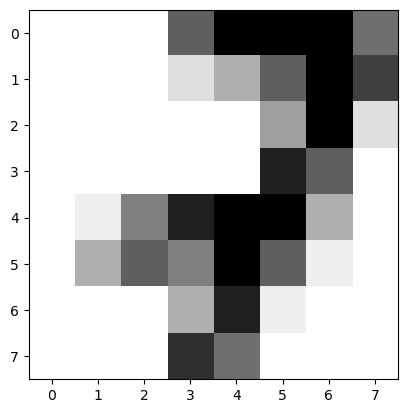


End autoencoder anomaly detection demo 



In [12]:
# 5. show most anomalous item
print("Largest reconstruction item / error: ")
(idx,err) = err_list[0]
print(" [%4d]  %0.4f" % (idx, err)) 
display_digit(data_ds, idx)

print("\nEnd autoencoder anomaly detection demo \n")